In [41]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                            confusion_matrix, roc_auc_score, roc_curve,auc)
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import warnings

data=pd.read_csv('/home/tisinr/Dev/models/classifier/dataset/bank.csv',header=0, sep=';')
# Display the first few rows of the dataset
print(data.head())


   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


In [ ]:
def rename_n_change(data):
    # Rename columns for better readability
    data.rename(columns={
        'marital':'marital_status',
        'default':'credit_default',
        'housing':'housing_loan',
        'loan':'personal_loan',
        'y':'response'}, inplace=True)
    #change data types for faster loading
    data['response'] = data['response'].astype('category')
    data['marital_status'] = data['marital_status'].astype('category')
    data['education'] = data['education'].astype('category')
    data['job'] = data['job'].astype('category')
    data['contact'] = data['contact'].astype('category')
    data['month'] = data['month'].astype('category')
    data['day'] = data['day'].astype('category')
    data['credit_default'] = data['credit_default'].astype('category')
    data['housing_loan'] = data['housing_loan'].astype('category')
    data['personal_loan'] = data['personal_loan'].astype('category')
    return data
data=rename_n_change(data)


In [ ]:
# Create subplots for the categorical variables
plt.figure(figsize=(18, 12))  

for i, variable in enumerate(categorical_features, 1):
    plt.subplot(4, 4, i)  # Create a 4x4 grid of subplots
    sns.countplot(data=data, x=variable, order=data[variable].value_counts().index)
    plt.title(f'{variable} Distribution')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout()  # Ensuring subplots do not overlap
plt.show()  # Display the plot

In [43]:
X=data.drop(columns=['response'])
y=data['response']

In [ ]:
## Apply preprocessing steps to the dataset
# Create a pipeline for preprocessing
numeric_features = ['age', 'balance', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital_status',  'day', 'education', 'month', 'housing_loan', 'personal_loan', 'credit_default']
# Create a column transformer to apply different preprocessing steps to different columns
pre_processor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
# Create a pipeline that first applies the preprocessor and then fits a classifier
pre_pipeline = Pipeline(steps=[
    ('preprocessor', pre_processor)
])


In [45]:
#Split the data into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,stratify=y,random_state=78)

# Label encode the response variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
# Fit preprocessing on training data and transform both sets
X_train = pre_pipeline.fit_transform(X_train)
X_test = pre_pipeline.transform(X_test)  # No fitting on test data!

In [47]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [48]:
#Logistic Regression
logreg=LogisticRegression(class_weight= 'balanced')
logreg.fit(X_train,y_train)

LogisticRegression(class_weight='balanced')

In [49]:
#Decision Tree Classifier
dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

In [50]:
#Random Forest Classifier
rforest=RandomForestClassifier(class_weight= 'balanced',n_estimators=100)
rforest.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced')

In [51]:
#Gradient Boosting Classifier
gbm=GradientBoostingClassifier()
gbm.fit(X_train,y_train)

GradientBoostingClassifier()

In [52]:
#Support Vector Classifier
svc=SVC(class_weight= 'balanced',probability=True)
svc.fit(X_train,y_train)

SVC(class_weight='balanced', probability=True)

In [53]:
#Gaussian Naive Bayes
gnb=GaussianNB()
gnb.fit(X_train,y_train)

GaussianNB()

In [54]:
#K Neighbors Classifier
knn=KNeighborsClassifier()
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [55]:
# Initialize optimized models
xgb = XGBClassifier(
    n_estimators=100,  # Allow more rounds, rely on early stopping
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=10
)
# Fit models with early stopping
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred=xgb.predict(X_test)

# Feature selection based on XGBoost importance
selector = SelectFromModel(xgb, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)



In [56]:
lgb = LGBMClassifier(
    n_estimators=100,
    max_depth=3,
    class_weight='balanced',
    num_leaves=15,  # Smaller for speed
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=10,
    verbose=-1
)
lgb.fit(X_train, y_train, eval_set=[(X_test, y_test)])


LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               early_stopping_rounds=10, max_depth=3, n_jobs=-1, num_leaves=15,
               random_state=42, subsample=0.8, verbose=-1)

In [63]:
# Update models list with fitted models
models = [
    ('Random Forest',rforest),
    ('SVC',svc), 
    ('XGBoost', xgb),
    ('Lightgbm', lgb),
    ('Gradient Boosting',gbm),
    ('Logistic Regression',logreg),
    ('K Neighbors',knn),
    ('Gaussian Naive Bayes',gnb),
    ('Decision Tree',dtree)  
]

In [ ]:
def plot_all_models_roc(models):

    plt.figure(figsize=(10, 8))
    sns.set_style('darkgrid')
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    
    # Iterate through models
    for model_name, model in models:
        
        # Get predicted probabilities
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    
    # Customize plot
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic - Model Comparison')
        plt.legend(loc='lower right')
        plt.grid(True)
    
    # Save plot
        plt.savefig('roc_comparison.png')
        #plt.close()
    return None


/home/tisinr/miniforge3/envs/clasfi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


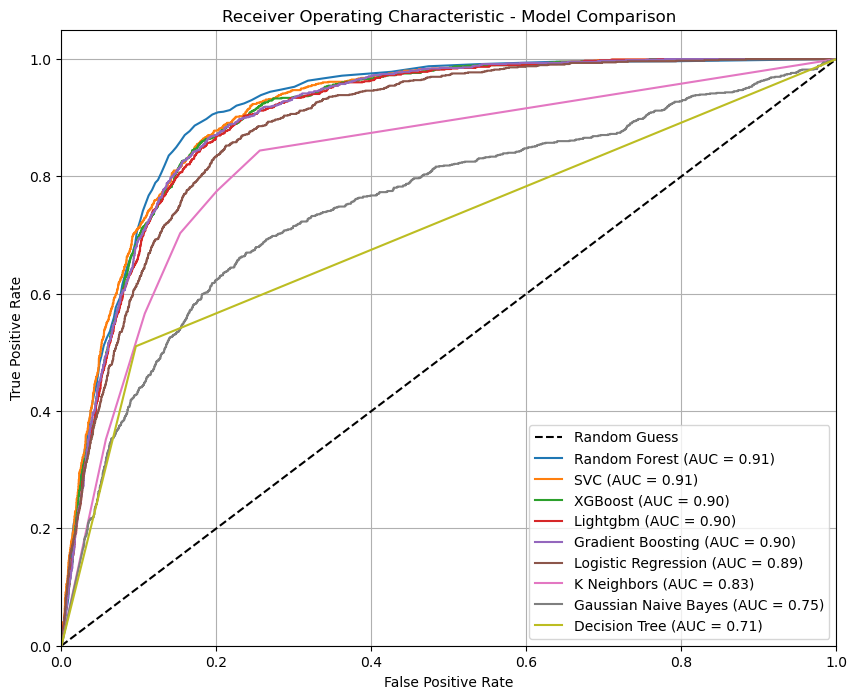

In [65]:

plot_all_models_roc(models)

In [ ]:
# Create a DataFrame to store the results
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVC', 'Gaussian Naive Bayes', 'K Neighbors'],
    'Accuracy': [accuracy_score(y_test, logreg.predict(X_test)), 
                 accuracy_score(y_test, dtree.predict(X_test)), 
                 accuracy_score(y_test, rforest.predict(X_test)), 
                 accuracy_score(y_test, gbm.predict(X_test)), 
                 accuracy_score(y_test, svc.predict(X_test)), 
                 accuracy_score(y_test, gnb.predict(X_test)), 
                 accuracy_score(y_test, knn.predict(X_test))],
    'ROC_AUC_Score': [roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, dtree.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, rforest.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, gbm.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, svc.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, gnb.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])]
})

In [ ]:
# Sort the results by ROC_AUC_Score in descending order
results = results.sort_values(by='ROC_AUC_Score', ascending = False,ignore_index = True)
# Display the results
print(results)

In [ ]:
# Save the model
joblib.dump(logreg, 'logreg_model.pkl')
joblib.dump(dtree, 'dtree_model.pkl')
joblib.dump(rforest, 'rforest_model.pkl')
joblib.dump(gbm, 'gbm_model.pkl')
joblib.dump(svc, 'svc_model.pkl')
joblib.dump(gnb, 'gnb_model.pkl')
joblib.dump(knn, 'knn_model.pkl')
joblib.dump(pre_pipeline, 'pre_pipeline.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')